In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import shap

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

import seaborn as sns

/home/tiaraedd/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
def optimal_model(X, y, title, features=None, do_shap=False):
    # create train test split and apply Standard Scaler
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    X_train = X_train.astype(float)
    X_test = X_test.astype(float)
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # intialize model and parameters
    xgb_tree = XGBRegressor()

    param_grid = {
        'alpha' : [0.01, 0.1, 1.],
        'gamma' : [0.01, 0.1, 1.],
        'lambda' : [0.01, 0.1, 1.],
        'eta' : [0.1, 0.2, 0.3, 0.4]
    }

    # perform grid search
    xgb_grid_search = GridSearchCV(xgb_tree, param_grid, scoring="neg_mean_squared_error", n_jobs=-1)
    xgb_grid_search.fit(X_train, y_train)
    print(title)
    print()

    # evaluate and print results
    best_xgb = xgb_grid_search.best_estimator_
    print(xgb_grid_search.best_params_)
    print(f"Best MSE: {-1 * xgb_grid_search.best_score_}")
    y_pred = best_xgb.predict(X_test)
    print(f"R^2 Score: {r2_score(y_test, y_pred)}")

    if features is not None:
        # print and plot feature analysis
        best_xgb = xgb_grid_search.best_estimator_

        feature_importance = best_xgb.feature_importances_
        index = np.argsort(feature_importance)[::-1]
        top3 = index[:3]
        print("Most important features: ", np.array(features)[top3])

        plt.barh(features, feature_importance)
        plt.suptitle(title)
        plt.title("Feature Importance")
        plt.show()
    
    if do_shap:
        explainer = shap.Explainer(best_xgb, X_train)
        shap_values = explainer(X_test)

        win_index = features.index('WIN_RATE')

        plt.figure()
        shap.summary_plot(shap_values, X_test, feature_names=features)

        win_rates = X_test[:, win_index]
        shap_win_values = shap_values.values[:, win_index]

        x_vals = np.linspace(np.min(win_rates)-.1, np.max(win_rates)+.1, 50)
        slope, intercept = np.polyfit(win_rates, shap_win_values, 1)

        # plt.figure()
        # shap.dependence_plot(
        #     ind=win_index,
        #     shap_values = shap_values.values,
        #     features=X_test,
        #     feature_names=features,
        # )
        plt.figure()
        plt.scatter(win_rates, shap_win_values, c=y_test, cmap='bwr', alpha=0.75, s=4)
        plt.plot(x_vals, slope * x_vals + intercept, 'k')
        plt.colorbar(label=f"Value of {title}")
        plt.xlabel('Win Rate (Adjusted)')
        plt.ylabel(f'Contribution of Win Rate to {title}')
        plt.title(f"Interaction Between Win Rate and {title}")
        plt.show()

        # plt.figure()
        # shap.dependence_plot(index[0], shap_values.values, X_test, feature_names=features)


In [24]:
def feature_importance(TARGET, df=None):
    if df is None:
        df = pd.read_csv("football_admission_cleaned.csv") 
    else:
        df = df.copy()

    teams = df["TEAM"].unique().tolist()
    # print(teams)
    cols = df.columns.tolist()
    # print(cols)

    targets = ['ADM_RATE', 'UGDS', 'ACTCMMID', 'SAT_AVG', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_MEN', 'UGDS_WOMEN']
    y = df[TARGET].values
    df.drop(columns=targets, inplace=True)
    df.drop(columns=['TEAM', 'INSTNM', 'YEAR'], inplace=True)
    df.drop(columns=['WON', 'LOST', 'TIED'], inplace=True)
    X = df.values

    cols = df.columns.tolist()

    optimal_model(X, y, TARGET, cols, do_shap=True)

In [ ]:
targets = ['ADM_RATE', 'UGDS', 'ACTCMMID', 'SAT_AVG', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_MEN', 'UGDS_WOMEN']
demo = ['UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_MEN', 'UGDS_WOMEN']
for target in demo:
    feature_importance(target)


In [32]:
def cluster(N=3):
    df = pd.read_csv("football_admission_cleaned.csv")
    # teams = df['TEAM'].unique().tolist()
    money_cols = ['TUITIONFEE_IN', 'TUITIONFEE_OUT', 'ON_CAMPUS_EXPENSES', 'OFF_CAMPUS_EXPENSES']
    money_df = df[money_cols]
    money_data = money_df.values

    kmeans = KMeans(n_clusters=N, random_state=42)
    kmeans.fit(money_data)
    labels = kmeans.predict(money_data)
    print(labels)

    df['COST_GROUP'] = labels

    return df
df = cluster()
money_cols = ['TUITIONFEE_IN', 'TUITIONFEE_OUT', 'ON_CAMPUS_EXPENSES', 'OFF_CAMPUS_EXPENSES']
for group in [0, 1, 2]:
    mask = df['COST_GROUP'] == group
    group_df = df[mask].copy()
    means = group_df[money_cols].mean()
    print(group)
    print(means)

[2 2 2 ... 0 0 0]
0
TUITIONFEE_IN          15414.569283
TUITIONFEE_OUT         28300.271672
ON_CAMPUS_EXPENSES     14231.804096
OFF_CAMPUS_EXPENSES    14148.940329
dtype: float64
1
TUITIONFEE_IN          46901.627760
TUITIONFEE_OUT         46957.735016
ON_CAMPUS_EXPENSES     16609.017350
OFF_CAMPUS_EXPENSES    14195.125176
dtype: float64
2
TUITIONFEE_IN           5611.706174
TUITIONFEE_OUT         14064.715546
ON_CAMPUS_EXPENSES     10547.516538
OFF_CAMPUS_EXPENSES    11173.676397
dtype: float64


MEDIUM COST

UGDS_WHITE

{'alpha': 1.0, 'eta': 0.1, 'gamma': 0.01, 'lambda': 0.01}
Best MSE: 0.02466397632669896
R^2 Score: 0.7048358642664116
Most important features:  ['TUITIONFEE_IN' 'REGION' 'RET_FT4']


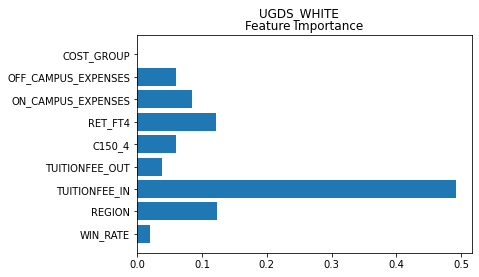

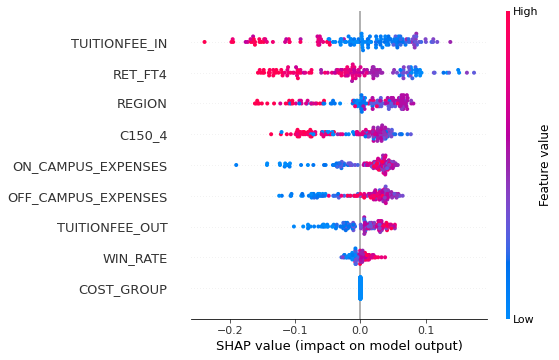

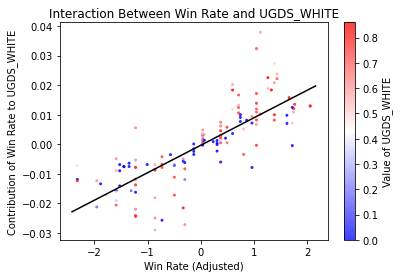

UGDS_BLACK

{'alpha': 0.01, 'eta': 0.2, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 0.0008108408828600778
R^2 Score: 0.8387351063821842
Most important features:  ['C150_4' 'REGION' 'OFF_CAMPUS_EXPENSES']


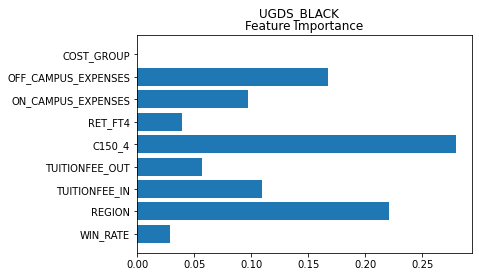

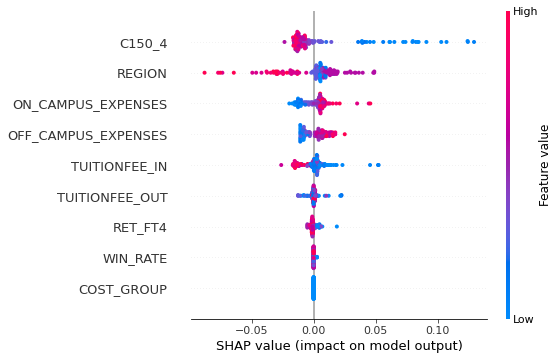

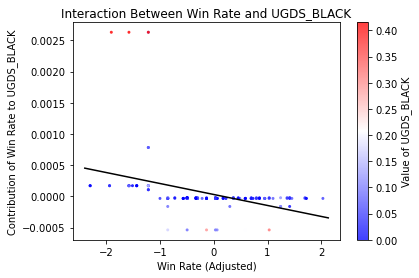

UGDS_HISP

{'alpha': 0.01, 'eta': 0.1, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 0.0011813463257542042
R^2 Score: 0.8070714067753733
Most important features:  ['REGION' 'WIN_RATE' 'C150_4']


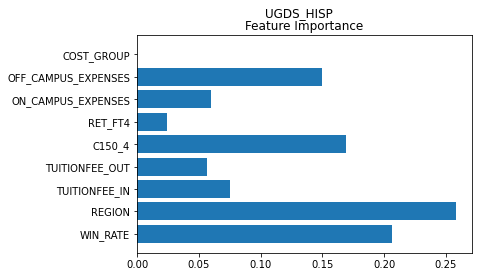

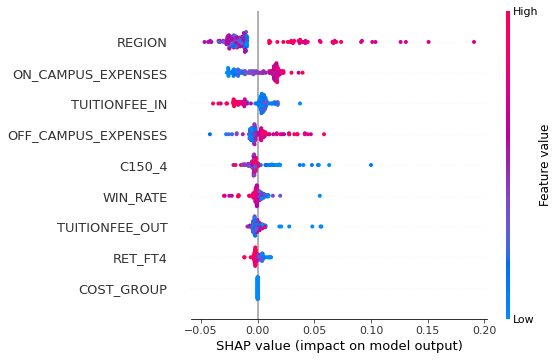

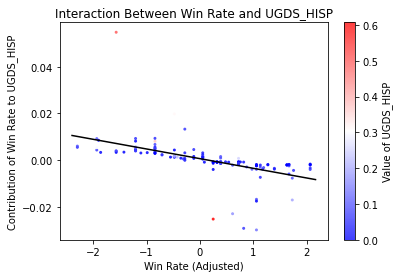

UGDS_ASIAN

{'alpha': 0.01, 'eta': 0.2, 'gamma': 0.01, 'lambda': 0.01}
Best MSE: 0.00148784582616311
R^2 Score: 0.7264124103509063
Most important features:  ['REGION' 'OFF_CAMPUS_EXPENSES' 'RET_FT4']


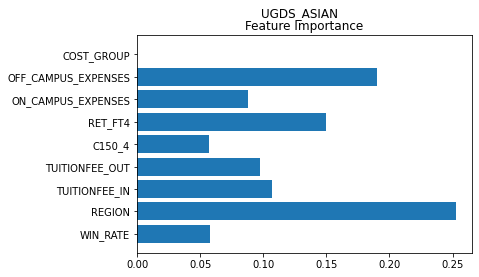

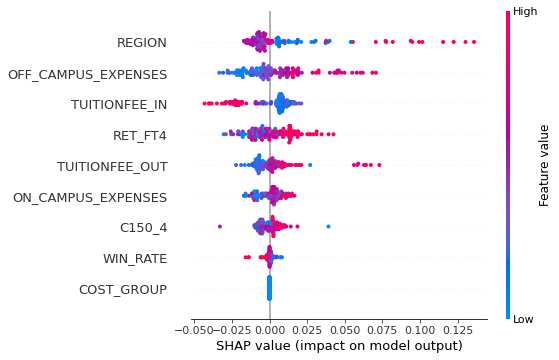

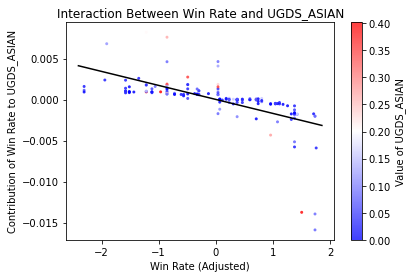

UGDS_MEN

{'alpha': 0.01, 'eta': 0.4, 'gamma': 0.01, 'lambda': 0.1}
Best MSE: 0.0025797655495400093
R^2 Score: 0.28249251449061463
Most important features:  ['OFF_CAMPUS_EXPENSES' 'RET_FT4' 'C150_4']


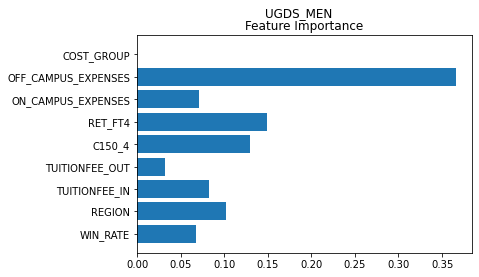

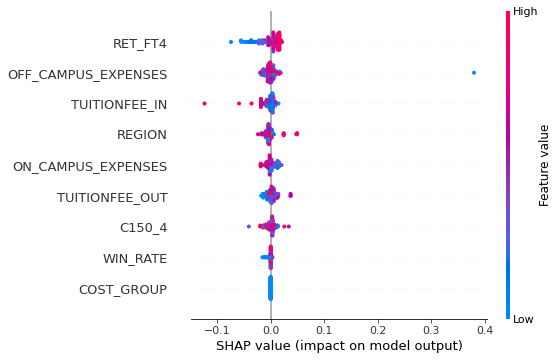

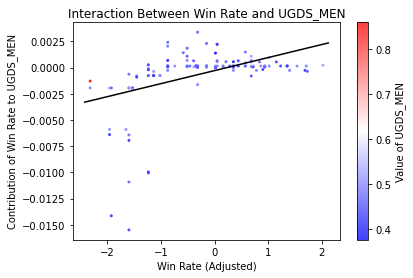

UGDS_WOMEN

{'alpha': 0.01, 'eta': 0.4, 'gamma': 0.01, 'lambda': 0.1}
Best MSE: 0.0022186835907181883
R^2 Score: 0.6012952157332883
Most important features:  ['OFF_CAMPUS_EXPENSES' 'REGION' 'C150_4']


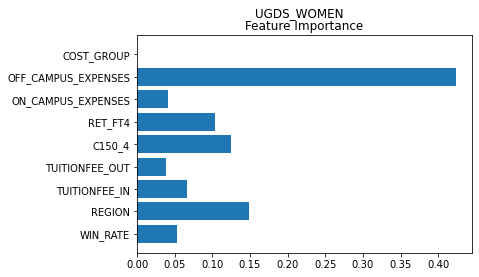

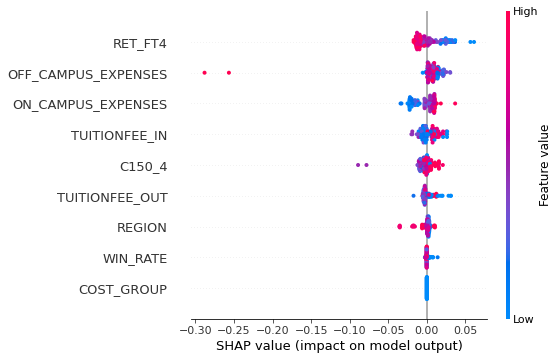

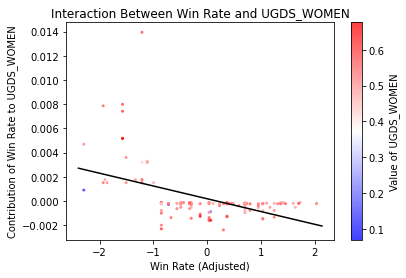

HIGH COST

UGDS_WHITE

{'alpha': 0.1, 'eta': 0.1, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 0.022130792365803044
R^2 Score: 0.5573263890247053
Most important features:  ['TUITIONFEE_OUT' 'RET_FT4' 'TUITIONFEE_IN']


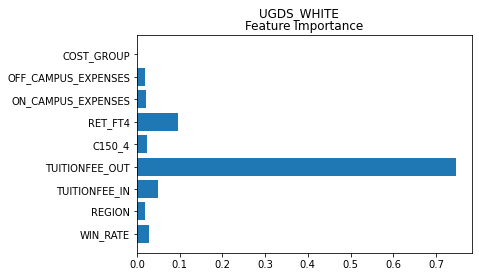

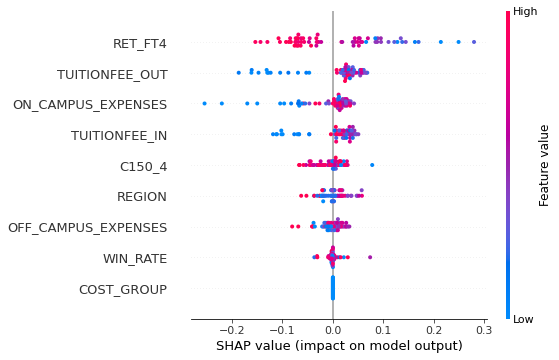

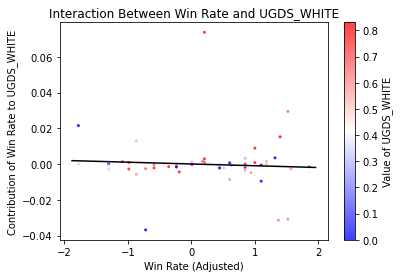

UGDS_BLACK

{'alpha': 0.01, 'eta': 0.4, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 0.00038717299649175627
R^2 Score: 0.4921516532991511
Most important features:  ['TUITIONFEE_OUT' 'C150_4' 'ON_CAMPUS_EXPENSES']


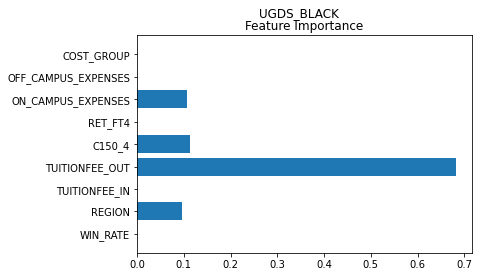

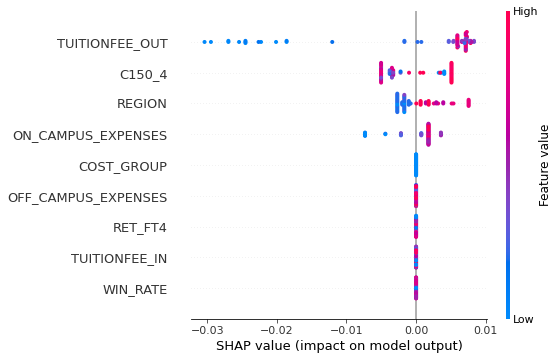

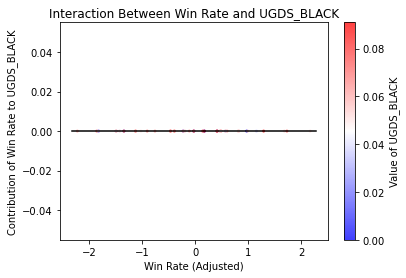

UGDS_HISP

{'alpha': 0.01, 'eta': 0.2, 'gamma': 0.01, 'lambda': 0.01}
Best MSE: 0.0009917403174073268
R^2 Score: 0.6530012692125293
Most important features:  ['TUITIONFEE_OUT' 'ON_CAMPUS_EXPENSES' 'OFF_CAMPUS_EXPENSES']


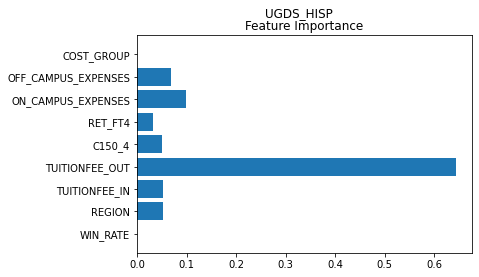

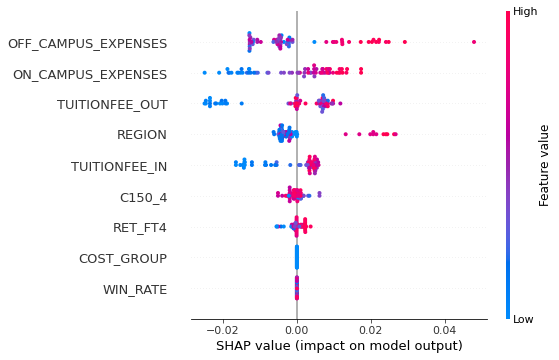

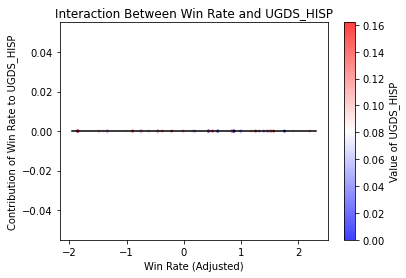

UGDS_ASIAN

{'alpha': 0.1, 'eta': 0.4, 'gamma': 0.01, 'lambda': 0.1}
Best MSE: 0.002114134062038853
R^2 Score: 0.7796232439005546
Most important features:  ['TUITIONFEE_OUT' 'RET_FT4' 'C150_4']


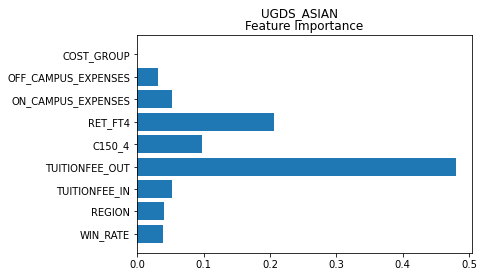

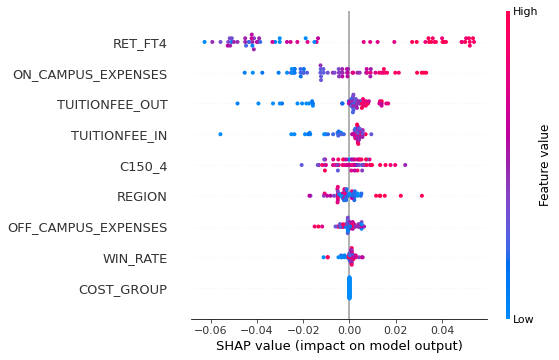

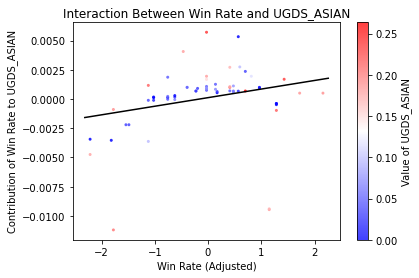

UGDS_MEN

{'alpha': 0.01, 'eta': 0.4, 'gamma': 0.01, 'lambda': 0.01}
Best MSE: 0.0008490571500941749
R^2 Score: 0.4037729359571758
Most important features:  ['RET_FT4' 'OFF_CAMPUS_EXPENSES' 'TUITIONFEE_IN']


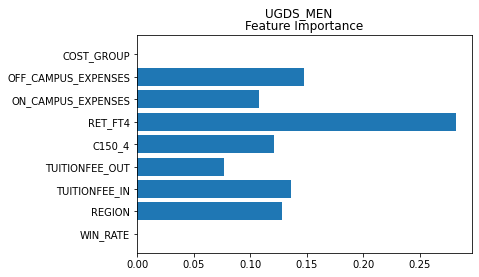

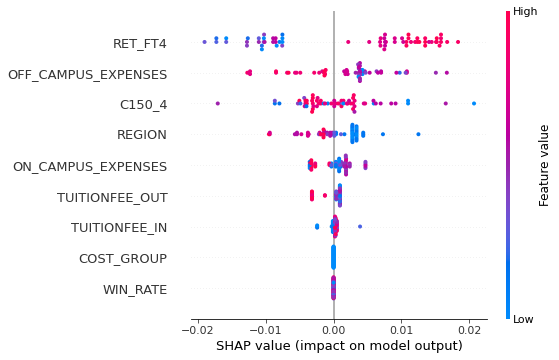

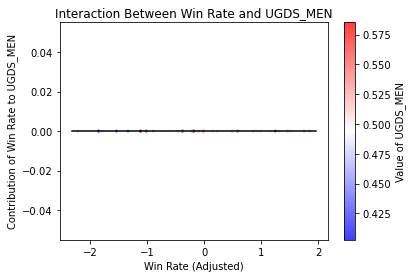

UGDS_WOMEN

{'alpha': 0.01, 'eta': 0.4, 'gamma': 0.01, 'lambda': 0.1}
Best MSE: 0.0009246556654630761
R^2 Score: 0.4882438271196833
Most important features:  ['RET_FT4' 'C150_4' 'OFF_CAMPUS_EXPENSES']


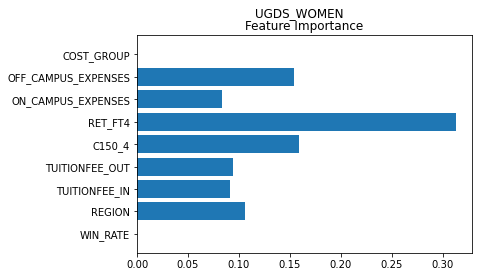

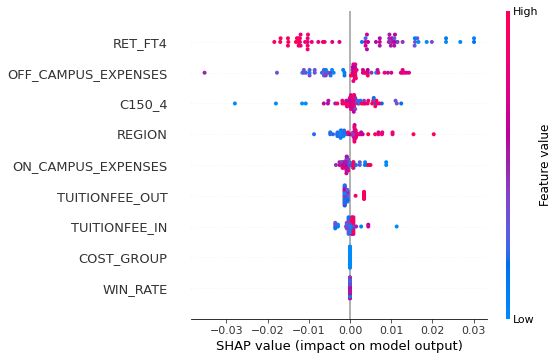

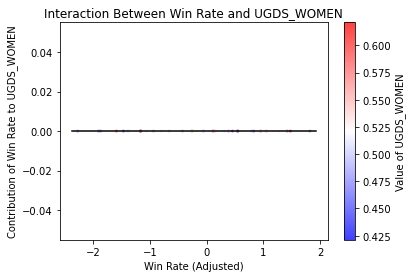

LOW COST

UGDS_WHITE

{'alpha': 0.1, 'eta': 0.1, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 0.03495989629795579
R^2 Score: 0.6580858084856663
Most important features:  ['ON_CAMPUS_EXPENSES' 'REGION' 'TUITIONFEE_IN']


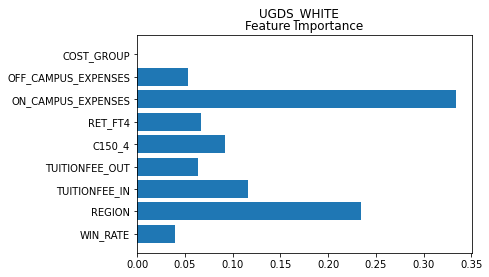

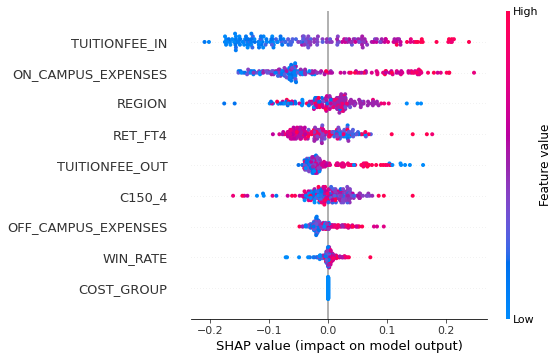

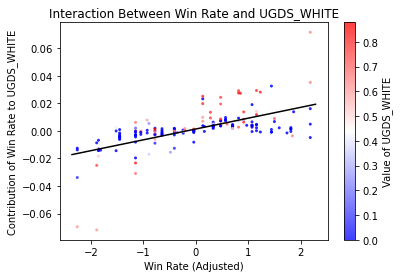

UGDS_BLACK

{'alpha': 0.1, 'eta': 0.1, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 0.001926472865880529
R^2 Score: 0.6783846693363822
Most important features:  ['OFF_CAMPUS_EXPENSES' 'REGION' 'C150_4']


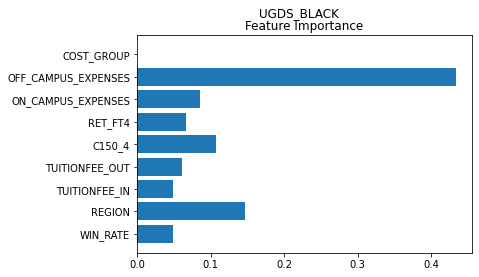

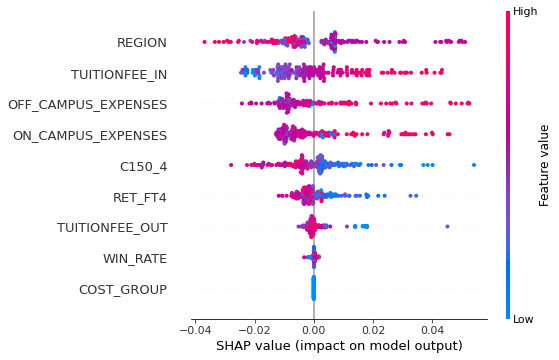

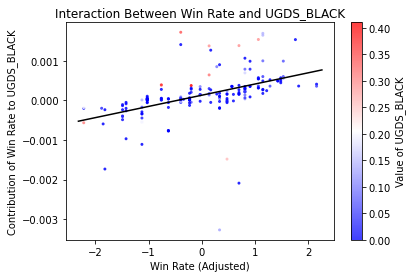

UGDS_HISP

{'alpha': 0.1, 'eta': 0.2, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 0.0030937618216728647
R^2 Score: 0.6553762618624797
Most important features:  ['ON_CAMPUS_EXPENSES' 'OFF_CAMPUS_EXPENSES' 'REGION']


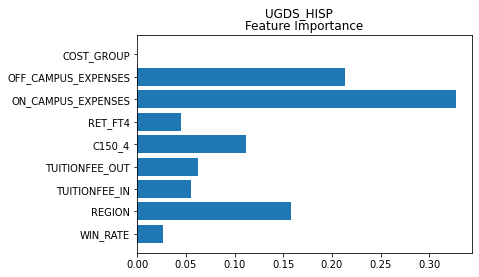

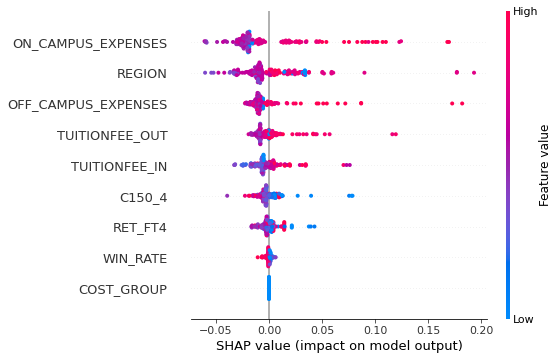

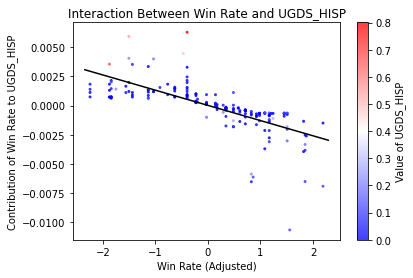

UGDS_ASIAN

{'alpha': 0.01, 'eta': 0.4, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 0.0005933012062724496
R^2 Score: 0.8019818959090844
Most important features:  ['OFF_CAMPUS_EXPENSES' 'REGION' 'C150_4']


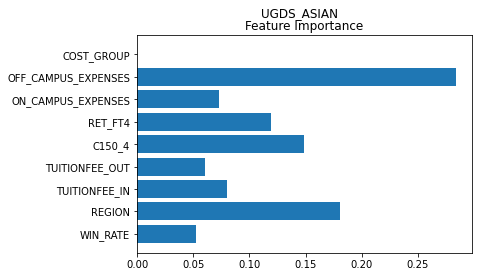

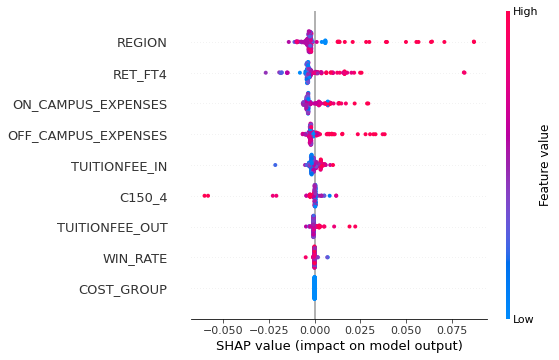

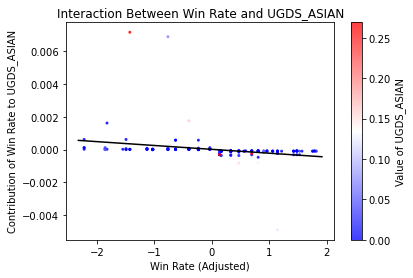

UGDS_MEN

{'alpha': 0.01, 'eta': 0.4, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 0.0021443019713447823
R^2 Score: 0.6840978977585379
Most important features:  ['OFF_CAMPUS_EXPENSES' 'C150_4' 'REGION']


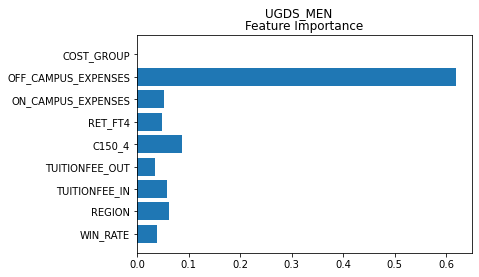

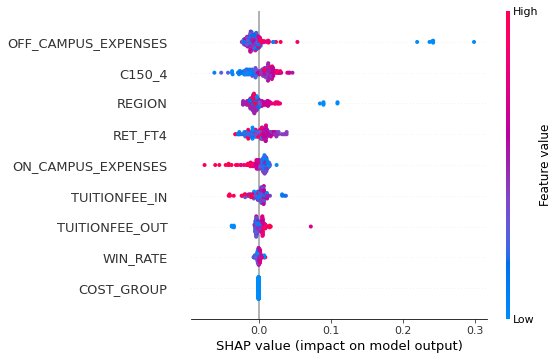

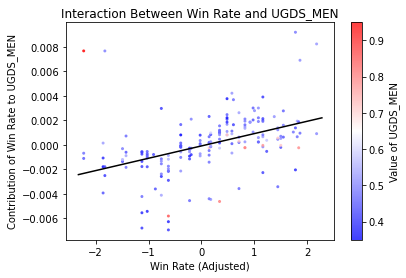

UGDS_WOMEN

{'alpha': 0.01, 'eta': 0.2, 'gamma': 0.01, 'lambda': 0.01}
Best MSE: 0.0021184825431378776
R^2 Score: 0.734799250936266
Most important features:  ['OFF_CAMPUS_EXPENSES' 'C150_4' 'ON_CAMPUS_EXPENSES']


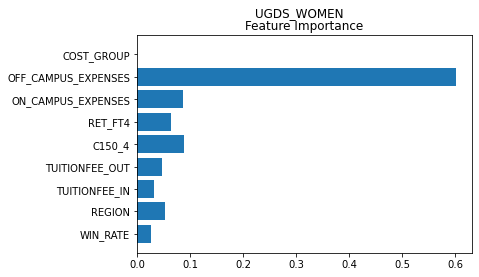

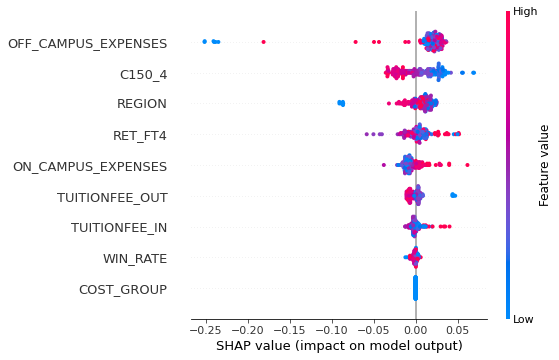

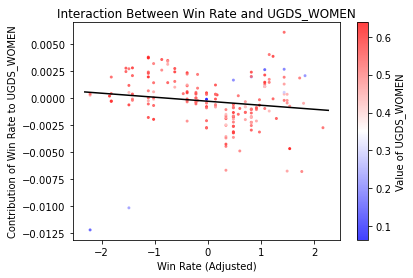

In [36]:
targets = ['ADM_RATE', 'UGDS', 'ACTCMMID', 'SAT_AVG', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_MEN', 'UGDS_WOMEN']
enroll = ['ADM_RATE', 'UGDS']
caliber = ['ACTCMMID', 'SAT_AVG']
demo = ['UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_MEN', 'UGDS_WOMEN']
group = 0

group_labels = ["MEDIUM COST", "HIGH COST", "LOW COST"]

for i, group in enumerate([0, 1, 2]):
    print(group_labels[i])
    print()
    mask = df['COST_GROUP'] == group
    group_df = df[mask].copy()

    for target in demo:
        feature_importance(target, df=group_df)

In [16]:
df

,TEAM,YEAR,WON,LOST,TIED,WIN_RATE,REGION,ADM_RATE,ACTCMMID,SAT_AVG,UGDS,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,TUITIONFEE_IN,TUITIONFEE_OUT,C150_4,RET_FT4,UGDS_MEN,UGDS_WOMEN,ON_CAMPUS_EXPENSES,OFF_CAMPUS_EXPENSES,INSTNM,COST_GROUP
0,Air_Force,2022,3.0,3.0,0.0,0.500000,0.0,0.1623,32.0,1401.0,4085.0,0.6345,0.0583,0.1192,0.0722,0.0,0.0,0.9991,0.9354,0.70550,0.29450,0.0,0.0,United States Air Force Academy,2
1,Air_Force,2021,11.0,2.0,0.0,0.846154,0.0,0.1243,32.0,1382.0,4181.0,0.6398,0.0636,0.1136,0.0703,0.0,0.0,0.8609,0.9253,0.71440,0.28560,0.0,0.0,United States Air Force Academy,2
2,Air_Force,2020,5.0,7.0,0.0,0.416667,0.0,0.1343,31.0,1371.0,4307.0,0.6373,0.0662,0.1145,0.0662,0.0,0.0,0.8732,0.9335,0.71980,0.28020,0.0,0.0,United States Air Force Academy,2
3,Air_Force,2019,5.0,7.0,0.0,0.416667,0.0,0.1108,31.0,1368.0,4304.0,0.6417,0.0655,0.1078,0.0583,0.0,0.0,0.8526,0.9394,0.72420,0.27580,0.0,0.0,United States Air Force Academy,2
4,Air_Force,2018,10.0,3.0,0.0,0.769231,0.0,0.1139,31.0,1366.0,4336.0,0.6301,0.0632,0.1063,0.0570,0.0,0.0,0.8501,0.9527,0.73250,0.26750,0.0,0.0,United States Air Force Academy,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3908,Yale,2002,7.0,3.0,0.0,0.700000,1.0,0.1376,32.0,1465.0,5302.0,0.0000,0.0000,0.0000,0.0000,27130.0,27130.0,0.9494,0.9900,0.50170,0.49830,11140.0,11140.0,Yale University,0
3909,Yale,2001,9.0,1.0,0.0,0.900000,1.0,0.1617,32.0,1465.0,5282.0,0.0000,0.0000,0.0000,0.0000,26100.0,26100.0,0.9404,0.9900,0.50640,0.49360,11140.0,11140.0,Yale University,0
3910,Yale,2000,6.0,4.0,0.0,0.600000,1.0,0.1617,32.0,1465.0,5274.0,0.0000,0.0000,0.0000,0.0000,26100.0,26100.0,0.9459,0.9900,0.50645,0.49355,11140.0,11140.0,Yale University,0
3911,Yale,1999,2.0,8.0,0.0,0.200000,1.0,0.1617,32.0,1465.0,5266.0,0.0000,0.0000,0.0000,0.0000,26100.0,26100.0,0.9453,0.9900,0.50650,0.49350,11140.0,11140.0,Yale University,0


In [131]:
def feature_categories(TARGET, TYPE):
    df = pd.read_csv("data_with_uni_type.csv")
    mask = df['University_Type'] == TYPE
    df = df[mask].copy()

    teams = df["TEAM"].unique().tolist()
    # print(teams)
    cols = df.columns.tolist()
    # print(cols)

    targets = ['ADM_RATE', 'UGDS', 'ACTCMMID', 'SAT_AVG', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_MEN', 'UGDS_WOMEN']
    y = df[TARGET].values
    df.drop(columns=targets, inplace=True)
    df.drop(columns=['TEAM', 'INSTNM', 'YEAR'], inplace=True)
    df.drop(columns=['WON', 'LOST', 'TIED'], inplace=True)
    df.drop(columns=['University_Type'], inplace=True)
    X = df.values
    cols = df.columns.tolist()

    optimal_model(X, y, TARGET, cols)

Military
UGDS

{'alpha': 1.0, 'eta': 0.1, 'gamma': 1.0, 'lambda': 0.01}
Best MSE: 991792.6006087807
R^2 Score: -12.62228041411167
Most important features:  ['RET_FT4' 'C150_4' 'WIN_RATE']


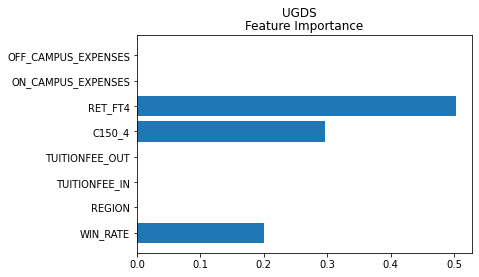

Public
UGDS

{'alpha': 1.0, 'eta': 0.2, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 15923416.72389191
R^2 Score: 0.8804035266597348
Most important features:  ['RET_FT4' 'TUITIONFEE_IN' 'REGION']


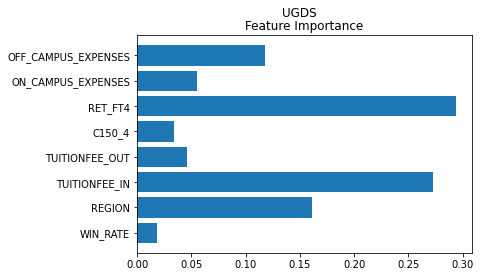

Private
UGDS

{'alpha': 0.01, 'eta': 0.1, 'gamma': 0.01, 'lambda': 1.0}
Best MSE: 2151559.8617309397
R^2 Score: 0.6257982818026959
Most important features:  ['REGION' 'RET_FT4' 'OFF_CAMPUS_EXPENSES']


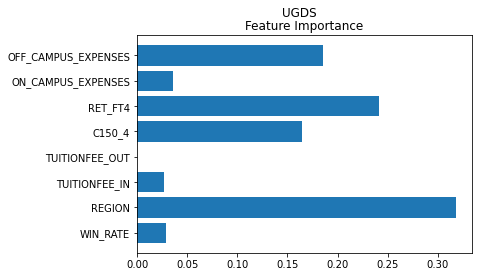

Religious
UGDS

{'alpha': 1.0, 'eta': 0.3, 'gamma': 0.1, 'lambda': 1.0}
Best MSE: 10476377.464803837
R^2 Score: 0.9819700177714474
Most important features:  ['REGION' 'RET_FT4' 'OFF_CAMPUS_EXPENSES']


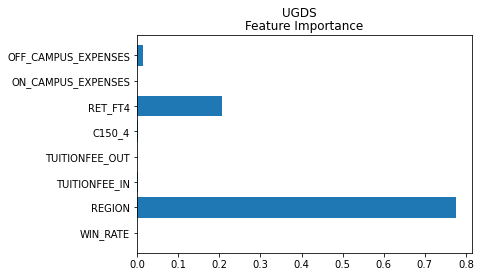

Unknown
UGDS

{'alpha': 1.0, 'eta': 0.4, 'gamma': 1.0, 'lambda': 1.0}
Best MSE: 1860920.3888927586
R^2 Score: 0.8021166103771858
Most important features:  ['TUITIONFEE_IN' 'OFF_CAMPUS_EXPENSES' 'TUITIONFEE_OUT']


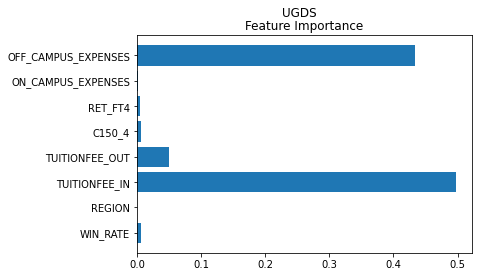

In [132]:
types = ['Military', 'Public', 'Private', 'Religious', 'Unknown']
for type in types:
    print(type)
    feature_categories('UGDS', type)

In [ ]:
df = pd.read_csv("data_with_uni_type.csv")
# df['University_Type'] = df['University_Type'].astype('category').cat.codes
# category_mapping = dict(enumerate(df['University_Type'].cat.categories))
df['University_Type'] = df['University_Type'].astype('category')
df['Type_Codes'] = df['University_Type'].cat.codes

# Get category-to-code mapping
category_mapping = dict(enumerate(df['University_Type'].cat.categories))
print(category_mapping)



{0: 'Military', 1: 'Private', 2: 'Public', 3: 'Religious', 4: 'Unknown'}


In [111]:
df

,TEAM,YEAR,WON,LOST,TIED,WIN_RATE,REGION,ADM_RATE,ACTCMMID,SAT_AVG,...,TUITIONFEE_OUT,C150_4,RET_FT4,UGDS_MEN,UGDS_WOMEN,ON_CAMPUS_EXPENSES,OFF_CAMPUS_EXPENSES,INSTNM,University_Type,Type_Codes
0,Air_Force,2022,3.0,3.0,0.0,0.500000,0.0,0.1623,32.0,1401.0,...,0.0,0.9991,0.9354,0.70550,0.29450,0.0,0.0,United States Air Force Academy,Military,0
1,Air_Force,2021,11.0,2.0,0.0,0.846154,0.0,0.1243,32.0,1382.0,...,0.0,0.8609,0.9253,0.71440,0.28560,0.0,0.0,United States Air Force Academy,Military,0
2,Air_Force,2020,5.0,7.0,0.0,0.416667,0.0,0.1343,31.0,1371.0,...,0.0,0.8732,0.9335,0.71980,0.28020,0.0,0.0,United States Air Force Academy,Military,0
3,Air_Force,2019,5.0,7.0,0.0,0.416667,0.0,0.1108,31.0,1368.0,...,0.0,0.8526,0.9394,0.72420,0.27580,0.0,0.0,United States Air Force Academy,Military,0
4,Air_Force,2018,10.0,3.0,0.0,0.769231,0.0,0.1139,31.0,1366.0,...,0.0,0.8501,0.9527,0.73250,0.26750,0.0,0.0,United States Air Force Academy,Military,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3908,Yale,2002,7.0,3.0,0.0,0.700000,1.0,0.1376,32.0,1465.0,...,27130.0,0.9494,0.9900,0.50170,0.49830,11140.0,11140.0,Yale University,Private,1
3909,Yale,2001,9.0,1.0,0.0,0.900000,1.0,0.1617,32.0,1465.0,...,26100.0,0.9404,0.9900,0.50640,0.49360,11140.0,11140.0,Yale University,Private,1
3910,Yale,2000,6.0,4.0,0.0,0.600000,1.0,0.1617,32.0,1465.0,...,26100.0,0.9459,0.9900,0.50645,0.49355,11140.0,11140.0,Yale University,Private,1
3911,Yale,1999,2.0,8.0,0.0,0.200000,1.0,0.1617,32.0,1465.0,...,26100.0,0.9453,0.9900,0.50650,0.49350,11140.0,11140.0,Yale University,Private,1
